# Features Selection: Scikit Learn

Collection of features selection techniques provided by Scikit Learn:

In [18]:
%matplotlib inline
import sys
sys.path.append('../../')  
from tools.reader import csv2df as reader, get_dcol
from preprocessing.preparation import full as preprocess
from preprocessing.scalers import normalization
from tools.columns import num2cal
from models.metrics import metrics_regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy
from datasets import solar

### arguments

In [19]:
ncv = 5
njobs = -1
delcols = ['hforecast', 'year', 'month', 'diffAPCP267', 'diffDSWRF267']

### load data

In [20]:
data, dcol = solar.load()
# filter columns
data.drop(delcols, axis=1, inplace=True)
dcol = get_dcol(data,ltarget = ['y', 'cy'])
# display
print('Period: %s - %s'%(data.index.tolist()[0], data.index.tolist()[-1]))
data.info()

Load data..
Period: 2013-01-01 10:00:00 - 2015-12-31 23:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26029 entries, 2013-01-01 10:00:00 to 2015-12-31 23:00:00
Data columns (total 22 columns):
VGRD267       26029 non-null float64
UGRD267       26029 non-null float64
LCDC267       26029 non-null float64
MCDC267       26029 non-null float64
HCDC267       26029 non-null float64
TCDC267       26029 non-null float64
PRES267       26029 non-null float64
RH267         26029 non-null float64
TMP267        26029 non-null float64
APCP267       26029 non-null float64
HWS267        26029 non-null float64
cLCDC267      26029 non-null int64
cMCDC267      26029 non-null int64
cHCDC267      26029 non-null int64
cTCDC267      26029 non-null int64
logAPCP267    26029 non-null float64
cAPCP267      26029 non-null category
hour          26029 non-null int64
doy           26029 non-null int64
y             26029 non-null float64
cy            26029 non-null int64
DSWRF267      26029 non-null f

## NEW INTERVAL FEATURES

### calculate rate of cloud cover

In [21]:
def add_cc_rate(data:'df', svar:str, svart:str)->'df':
    if 'r%s'%svar in list(data.columns):
        pass
    else:
        data['r%s'%svar] = data[[svar, svart]].apply(lambda x: 0. if x[1]==0. else x[0] / x[1], axis = 1)
    return data
data = add_cc_rate(data, 'LCDC267', 'TCDC267')
data = add_cc_rate(data, 'MCDC267', 'TCDC267')
data = add_cc_rate(data, 'HCDC267', 'TCDC267')

### calculate differences with doy average (per hour)

In [22]:
def add_doy_diff(data:'df', svar:str)->'df':
    # validation
    if 'd%s'%svar in list(data.columns):
        return data
    # initialize
    dfaux = pd.DataFrame()
    hours = sorted(data.hour.unique())
    for ii,ihour in enumerate(hours):
        # collect data
        idata = data[data.hour==ihour][['doy',svar]]
        # calculate doy average
        dfavg = idata[['doy',svar]].groupby('doy').mean().reset_index()
        favg = lambda x: dfavg[dfavg.doy == x][svar].values[0]
        # calculate diff
        idata['D%s'%svar] = idata[['doy',svar]].apply(lambda x: x[1] - favg(x[0]),axis = 1)
        # append
        if ii ==0:
            dfaux = idata[['D%s'%svar]].copy()
        else:
            dfaux = dfaux.append(idata[['D%s'%svar]])
        # clean
        del(idata)
    # sort by index
    dfaux.sort_index(inplace = True)
    # drop nan
    dfaux.dropna(inplace = True)
    # concat with the original df and return
    return  pd.concat([data, dfaux], axis = 1)
data = add_doy_diff(data,'TMP267')
data = add_doy_diff(data,'RH267')

### calculate differences with previous day (per hour)

In [23]:
def add_hourly_diff(data:'df', svar:str)->'df':
    # validation
    if 'd%s'%svar in list(data.columns):
        return data
    # initialize
    dfaux = pd.DataFrame()
    # loop of hours
    hours = sorted(data.hour.unique())
    for ii,ihour in enumerate(hours):
        # collect data
        idata = data[data.hour==ihour][[svar]]
        # calculate diff
        idata['d%s'%svar] = idata[[svar]].diff()
        # append
        if ii ==0:
            dfaux = idata[['d%s'%svar]].copy()
        else:
            dfaux = dfaux.append(idata[['d%s'%svar]])
        # clean
        del(idata)
    # sort by index
    dfaux.sort_index(inplace = True)
    # drop nan
    dfaux.dropna(inplace = True)
    # concat with the original df and return
    return  pd.concat([data, dfaux], axis = 1)
# launch
data = add_hourly_diff(data,'TMP267')
data = add_hourly_diff(data,'RH267')

In [27]:
# drop nan values
data.dropna(inplace = True)
# update dcol
dcol = get_dcol(data,ltarget = ['y', 'cy'])

## pre-processing

In [29]:
# get list of column names
lcolx = dcol['lx']
lcolx_cat = dcol['lc_cat'].copy()
lcolx_num = lcolx.copy()
for ic in lcolx_cat:
    lcolx_num.remove(ic)

In [30]:
# y pre-processing
scaler = normalization.Scaler()
y = scaler.fit_transform(data[['y']]).ravel()
cy = data['cy'].values
#y = transformer(data['y']).ravel()

In [31]:
# X pre-processing
X = preprocess(data[lcolx_num + lcolx_cat])
# new columns
lcolx_new = lcolx_num + pd.get_dummies(data[lcolx_cat], prefix_sep='_', drop_first=True).columns.tolist()

# create samples
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_test, cy_train, cy_test =\
    train_test_split(X, cy, test_size=0.3, random_state=0, stratify=cy)

### Linear relationship X-y: Pearson Correlation

In [32]:
# lineal
corr_matrix = pd.get_dummies(data,columns = lcolx_cat, drop_first = True).corr()
print('Linear Correlation X-y:')
corr_matrix["y"].sort_values(ascending=False)

Linear Correlation X-y:


y                     1.000000
cy                    0.979088
DSWRF267              0.774453
TMP267                0.160927
VGRD267               0.092388
cAPCP267_soft rain    0.080655
dTMP267               0.041366
DTMP267               0.032370
PRES267               0.007038
hour                 -0.032450
UGRD267              -0.038897
doy                  -0.052526
rLCDC267             -0.074132
HWS267               -0.093843
rHCDC267             -0.095703
APCP267              -0.102673
cAPCP267_rain        -0.118346
dRH267               -0.121887
logAPCP267           -0.123222
cLCDC267             -0.132287
LCDC267              -0.133272
DRH267               -0.156054
cHCDC267             -0.169190
HCDC267              -0.170353
cTCDC267             -0.231951
TCDC267              -0.233302
rMCDC267             -0.263497
cMCDC267             -0.270095
MCDC267              -0.273216
RH267                -0.344913
Name: y, dtype: float64

### Linear relationship (F-test) vs Non-Linear relationship (Mutual Information) X-y: 

- Reference: ["Comparison of F-test and mutual information"](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py)

In [33]:
from sklearn.feature_selection import f_regression, mutual_info_regression
# calculate F-Test
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)
# calculate Mutual Information
mi = mutual_info_regression(X, y)
mi /= np.max(mi)
# store
lr = list()
for i in range(X.shape[1]):
    lr.append([lcolx_new[i],f_test[i], mi[i]])
dfrelation = pd.DataFrame(np.array(lr), columns = ['feature','FTest','MI']).set_index('feature')
dfrelation['FTest'] = dfrelation['FTest'].astype(float) 
dfrelation['MI'] = dfrelation['MI'].astype(float) 

In [34]:
print('SORTED by F-Test:')
dfrelation.sort_values(['FTest'], ascending=[0])

SORTED by F-Test:


,FTest,MI
feature,,
DSWRF267,1.000000,0.814212
RH267,0.090102,0.113682
MCDC267,0.053829,0.081431
cMCDC267,0.052510,0.074812
rMCDC267,0.049787,0.059613
TCDC267,0.038411,0.071302
cTCDC267,0.037942,0.063670
HCDC267,0.019944,0.039602
cHCDC267,0.019664,0.035878


In [35]:
print('SORTED by MI:')
dfrelation.sort_values(['MI'], ascending=[0])

SORTED by MI:


,FTest,MI
feature,,
hour,0.000703,1.000000
DSWRF267,1.000000,0.814212
RH267,0.090102,0.113682
MCDC267,0.053829,0.081431
cMCDC267,0.052510,0.074812
TCDC267,0.038411,0.071302
doy,0.001846,0.069378
TMP267,0.017740,0.066818
cTCDC267,0.037942,0.063670


### Linear relationship X(with crossed values)-y

In [36]:
lcolx_num_selection = ['RH267','hour','DSWRF267','MCDC267','TMP267']

In [37]:
## get polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
apoly = poly.fit_transform(data[lcolx_num_selection])

## get features names
lcol_polyaux = poly.get_feature_names()
dcolx_num = dict()
for ii, ic in enumerate(lcolx_num_selection):
    if ic!='bias':
        dcolx_num['x%s'%ii] = ic

In [38]:
# rename crossed columns
shead = ';'.join(lcol_polyaux)
for k,v in dcolx_num.items():
    shead = shead.replace(k,v)
lhead = shead.split(';')

In [39]:
## store in df and concat with y
DATAP = pd.DataFrame(np.c_[apoly,data[dcol['ly']]], columns = lhead + dcol['ly'])

# lineal
corr_matrix = DATAP.corr()
corr_matrix["y"].sort_values(ascending=False)

y                   1.000000
cy                  0.979088
DSWRF267            0.774453
RH267 DSWRF267      0.703149
DSWRF267^2          0.701270
hour DSWRF267       0.668463
DSWRF267 TMP267     0.641797
TMP267^2            0.182492
TMP267              0.160927
DSWRF267 MCDC267    0.084244
hour TMP267         0.053346
RH267 TMP267       -0.014825
hour               -0.032450
RH267 hour         -0.138915
hour^2             -0.196121
hour MCDC267       -0.224311
MCDC267 TMP267     -0.225101
MCDC267^2          -0.233390
RH267 MCDC267      -0.271709
MCDC267            -0.273216
RH267^2            -0.342005
RH267              -0.344913
1                        NaN
Name: y, dtype: float64

### add interesting crossed columns as features

In [40]:
# select cross features to be add
lcol_select = ['TMP267^2']
# add cross interested features
data_extra = data[lcolx_num].copy()
lcolx_new = lcolx_num + lcol_select
for ic in lcol_select:
    data_extra[ic] = DATAP[ic].values
data_extra = pd.concat([data_extra, data[lcolx_cat]], axis=1)

In [41]:
# X pre-processing
X = preprocess(data_extra)
# new columns
lcolx_new = lcolx_new + pd.get_dummies(data[lcolx_cat], prefix_sep='_', drop_first=True).columns.tolist()
# create samples
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_test, cy_train, cy_test =\
    train_test_split(X, cy, test_size=0.3, random_state=0, stratify=cy)

## ElasticNet (Regression)

- Optimal alpha: 4.50949563
- Optimal l1_ratio: 0.001
- Number of iterations 2


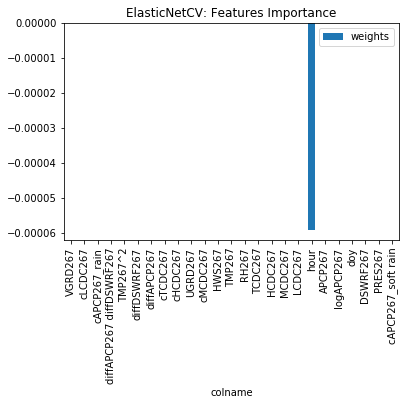

In [23]:
from sklearn.linear_model import ElasticNetCV

# regressor: ElasticNetCV (for tuning hyperparameters)
estimatorcv = ElasticNetCV(l1_ratio=[.0001, .001 , .1, .5, .7, .9, .95, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=False, precompute='auto', max_iter=5000, tol=0.0001, cv=ncv, 
                        copy_X=True, verbose=0, n_jobs=njobs, positive=False, random_state=None, selection='cyclic')
estimatorcv.fit(X_train, y_train)
print('- Optimal alpha: %.8f'%estimatorcv.alpha_)
print('- Optimal l1_ratio: %.3f'%estimatorcv.l1_ratio_)
print('- Number of iterations %d'%estimatorcv.n_iter_)
# plot features importance
import matplotlib.pyplot as plt
dfw = pd.DataFrame(np.c_[lcolx_new,np.array(estimatorcv.coef_)], columns = ['colname','weights']).sort_values(['weights'], ascending=[0]).set_index('colname')
dfw['weights'] = dfw['weights'].astype('float')
dfw.plot(kind='bar',title='ElasticNetCV: Features Importance')
plt.show()

## Sequential feature selection algorithms (Classification)

In [24]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

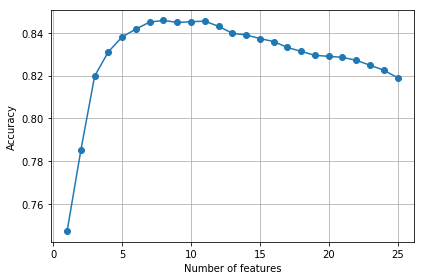

In [25]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X, cy)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
#plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [36]:
k3 = list(sbs.subsets_[17])
print(np.array(lcolx_new)[:][k3])

['APCP267' 'cLCDC267' 'cMCDC267' 'cHCDC267' 'hour' 'DSWRF267'
 'diffDSWRF267' 'TMP267^2']


In [37]:
knn.fit(X_train, cy_train)
print('Training accuracy:', knn.score(X_train, cy_train))
print('Test accuracy:', knn.score(X_test, cy_test))

Training accuracy: 0.870307354555
Test accuracy: 0.81546933026


In [38]:
knn.fit(X_train[:, k3], cy_train)
print('Training accuracy:', knn.score(X_train[:, k3], cy_train))
print('Test accuracy:', knn.score(X_test[:, k3], cy_test))

Training accuracy: 0.883973655324
Test accuracy: 0.843001664746


## Assessing feature importance with Random Forests (Classification)

 1) DSWRF267                       0.236651
 2) diffDSWRF267                   0.145866
 3) hour                           0.136532
 4) RH267                          0.048972
 5) doy                            0.040186
 6) TMP267                         0.036925
 7) TMP267^2                       0.035975
 8) VGRD267                        0.032252
 9) UGRD267                        0.030333
10) HWS267                         0.030253
11) MCDC267                        0.029993
12) PRES267                        0.029366
13) TCDC267                        0.027972
14) HCDC267                        0.019885
15) logAPCP267                     0.016373
16) APCP267                        0.016369
17) cMCDC267                       0.015884
18) LCDC267                        0.013888
19) cTCDC267                       0.012816
20) diffAPCP267                    0.012225
21) cHCDC267                       0.009720
22) diffAPCP267 diffDSWRF267       0.009170
23) cLCDC267                    

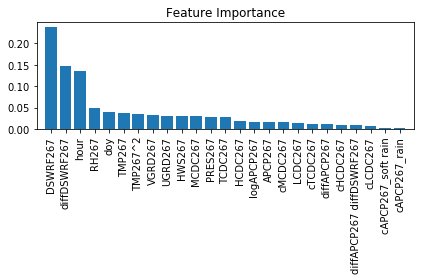

In [29]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = np.array(lcolx_new)

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1, n_jobs = -1)

forest.fit(X_train, cy_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

## Assessing feature importance with Random Forests (Regression)

 1) UGRD267                        0.096483
 2) PRES267                        0.092988
 3) RH267                          0.092021
 4) HWS267                         0.080209
 5) VGRD267                        0.078939
 6) doy                            0.060041
 7) diffDSWRF267                   0.054890
 8) TMP267                         0.049010
 9) TMP267^2                       0.048455
10) TCDC267                        0.042350
11) DSWRF267                       0.041459
12) hour                           0.041222
13) MCDC267                        0.037438
14) HCDC267                        0.035620
15) LCDC267                        0.031323
16) diffAPCP267                    0.028401
17) logAPCP267                     0.021117
18) APCP267                        0.020842
19) diffAPCP267 diffDSWRF267       0.015033
20) cHCDC267                       0.007193
21) cTCDC267                       0.007137
22) cMCDC267                       0.006212
23) cLCDC267                    

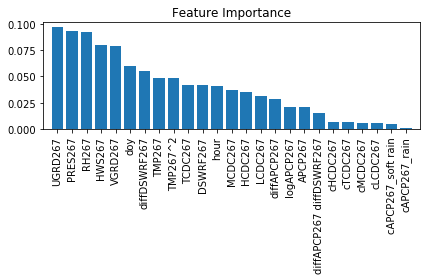

In [30]:
from sklearn.ensemble import RandomForestRegressor

feat_labels = np.array(lcolx_new)

forest = RandomForestRegressor(n_estimators=500,
                                random_state=1, n_jobs = -1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

## Using theBuilt-in XGBoost Feature Importance Plot (Classification)

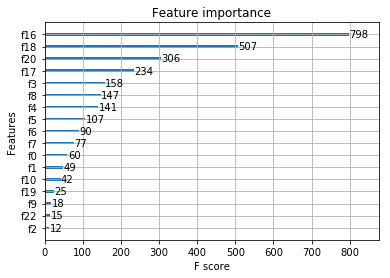

                     colname            importance
id                                                
16                      hour     0.286432147026062
18                  DSWRF267   0.18198134005069733
20              diffDSWRF267   0.10983488708734512
17                       doy    0.0839913859963417
3                    MCDC267  0.056712131947278976
8                     TMP267   0.05276381969451904
4                    HCDC267  0.050610192120075226
5                    TCDC267   0.03840631619095802
6                    PRES267   0.03230438008904457
7                      RH267  0.027638191357254982
0                    VGRD267   0.02153625339269638
1                    UGRD267  0.017587939277291298
10                    HWS267  0.015075377188622952
19               diffAPCP267  0.008973438292741776
9                    APCP267  0.006460875738412142
22  diffAPCP267 diffDSWRF267  0.005384063348174095
2                    LCDC267  0.004307250492274761
23             cAPCP267_rain   

In [31]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier()
model.fit(X_train, cy_train)
# plot feature importance
plot_importance(model)
pyplot.show()
# importance df
dfimportance = pd.DataFrame(np.c_[np.arange(len(lcolx_new)),np.array(lcolx_new),model.feature_importances_],columns=['id','colname','importance']).set_index('id').sort_values(['importance'], ascending=[0])
print(dfimportance)

In [32]:
model.fit(X_train, cy_train)
print('Training accuracy:', model.score(X_train, cy_train))
print('Test accuracy:', model.score(X_test, cy_test))

Training accuracy: 0.866190998902
Test accuracy: 0.850172877449


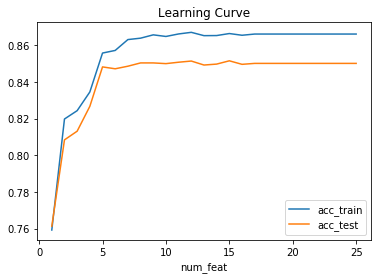

In [33]:
## LEARNING CURVE
lindex = [int(i) for i in dfimportance.index.tolist()]
lacc_train = list()
lacc_test = list()
for ii in list(range(1,len(lindex)+1,1)):
    model.fit(X_train[:,lindex[:ii]], cy_train)
    lacc_train.append(model.score(X_train[:,lindex[:ii]], cy_train))
    lacc_test.append(model.score(X_test[:,lindex[:ii]], cy_test))
dfacc = pd.DataFrame(list(zip(list(range(1,len(lindex)+1,1)), lacc_train, lacc_test)), columns = ['num_feat','acc_train','acc_test']).set_index('num_feat')
dfacc.plot(title="Learning Curve")

## Using theBuilt-in XGBoost Feature Importance Plot (Regression)

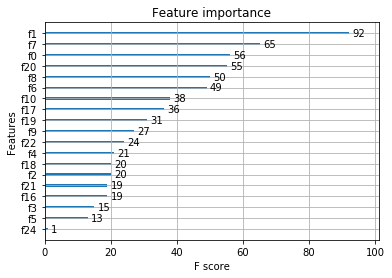

                     colname             importance
id                                                 
1                    UGRD267    0.14132104814052582
7                      RH267    0.09984639286994934
0                    VGRD267    0.08602150529623032
20              diffDSWRF267    0.08448540419340134
8                     TMP267    0.07680491358041763
6                    PRES267    0.07526881992816925
10                    HWS267   0.058371737599372864
17                       doy     0.0552995391190052
19               diffAPCP267     0.0476190485060215
9                    APCP267    0.04147465527057648
22  diffAPCP267 diffDSWRF267   0.036866359412670135
4                    HCDC267   0.032258063554763794
18                  DSWRF267   0.030721966177225113
2                    LCDC267   0.030721966177225113
21                  TMP267^2   0.029185868799686432
16                      hour   0.029185868799686432
3                    MCDC267    0.02304147556424141
5           

In [34]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)
# plot feature importance
plot_importance(model)
pyplot.show()
# importance df
dfimportance = pd.DataFrame(np.c_[np.arange(len(lcolx_new)),np.array(lcolx_new),model.feature_importances_],columns=['id','colname','importance']).set_index('id').sort_values(['importance'], ascending=[0])
print(dfimportance)

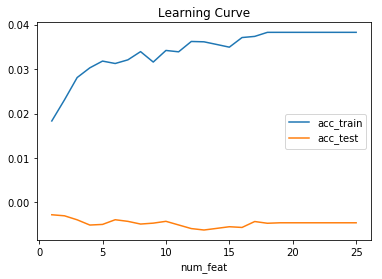

In [35]:
## LEARNING CURVE
lindex = [int(i) for i in dfimportance.index.tolist()]
lacc_train = list()
lacc_test = list()
for ii in list(range(1,len(lindex)+1,1)):
    model.fit(X_train[:,lindex[:ii]], y_train)
    lacc_train.append(model.score(X_train[:,lindex[:ii]], y_train))
    lacc_test.append(model.score(X_test[:,lindex[:ii]], y_test))
dfacc = pd.DataFrame(list(zip(list(range(1,len(lindex)+1,1)), lacc_train, lacc_test)), columns = ['num_feat','acc_train','acc_test']).set_index('num_feat')
dfacc.plot(title="Learning Curve")